In [121]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [122]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [123]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ["PYTHONHASHEED"] = str(seed_value)
    
SEED=42
set_seed(SEED)

In [124]:
train_df=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [125]:
print("Train shape:",train_df.shape)
train_df.sample(3)

Train shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
892,893,20,RL,70.0,8414,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal,154500
1105,1106,60,RL,98.0,12256,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,325000
413,414,30,RM,56.0,8960,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,115000


In [126]:
print("Test shape:",test_df.shape)
test_df.sample(3)

Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1084,2545,50,RL,74.0,16287,Pave,NaN,Reg,Lvl,AllPub,...,100,0,NaN,NaN,NaN,0,7,2007,WD,Normal
1416,2877,70,RL,69.0,4899,Pave,NaN,Reg,HLS,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
682,2143,85,RL,NaN,7400,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2008,WD,Normal


In [127]:
used_columns=["MSZoning","LotArea","Neighborhood","ExterQual","CentralAir","PoolArea"]
y_train=train_df["SalePrice"].values

X_train=train_df[used_columns]
X_test=test_df[used_columns]

In [128]:
X_train.isna().sum()

MSZoning        0
LotArea         0
Neighborhood    0
ExterQual       0
CentralAir      0
PoolArea        0
dtype: int64

In [129]:
X_test.isna().sum()

MSZoning        4
LotArea         0
Neighborhood    0
ExterQual       0
CentralAir      0
PoolArea        0
dtype: int64

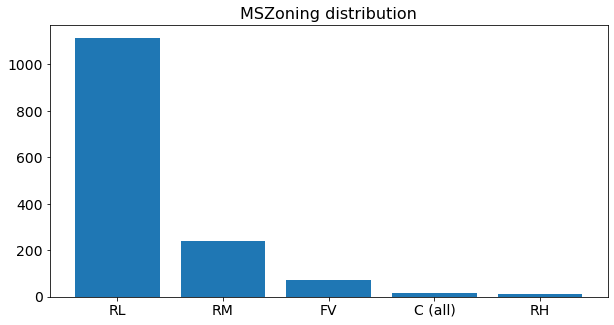

In [130]:
plt.figure(figsize=(10,5))

MSZoning_info = X_test["MSZoning"].value_counts()
plt.bar(MSZoning_info.index, MSZoning_info.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("MSZoning distribution", fontsize=16);

In [131]:
X_test["MSZoning"].fillna("RL", inplace=True) #欠損値を最頻値で埋めてみるって、これ本当は絶対やっちゃいけないけどね。。。
X_test.isna().sum()

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


MSZoning        0
LotArea         0
Neighborhood    0
ExterQual       0
CentralAir      0
PoolArea        0
dtype: int64

In [132]:
X_train.dtypes

MSZoning        object
LotArea          int64
Neighborhood    object
ExterQual       object
CentralAir      object
PoolArea         int64
dtype: object

In [133]:
categorical_columns=["MSZoning","Neighborhood","ExterQual","CentralAir"]

In [134]:
#カテゴリ変数はラベルエンコーダーで処理していく。
#https://qiita.com/sinchir0/items/b038757e578b790ec96a
#https://qiita.com/Hyperion13fleet/items/afa49a84bd5db65ffc31

import category_encoders as ce

ce_oe=ce.OrdinalEncoder(cols=categorical_columns, handle_unknown='impute')

#pd.DataFrameをそのまま突っ込む
X_train_ce_oe=ce_oe.fit_transform(X_train)

for category in categorical_columns:
    X_train_ce_oe[category]=X_train_ce_oe[category].astype("int")
    
X_train_ce_oe.dtypes

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


MSZoning        int64
LotArea         int64
Neighborhood    int64
ExterQual       int64
CentralAir      int64
PoolArea        int64
dtype: object

In [135]:
#testサンプルについても同じことをする
X_test_ce_oe=ce_oe.fit_transform(X_test)

for category in categorical_columns:
    X_test_ce_oe[category]=X_test_ce_oe[category].astype("int")
    
X_test_ce_oe.dtypes

MSZoning        int64
LotArea         int64
Neighborhood    int64
ExterQual       int64
CentralAir      int64
PoolArea        int64
dtype: object

In [136]:
#パラメータ調節
def param():
    param_grid= {
        'metric':['rmse'],
        'n_estimators':[5,10,15,25,50,100],
        'num_leaves': [5,10,15,30],
        'learning_date': [0.01,0.05,0.1]
    }
    
    return param_grid


model=lgbm.LGBMRegressor(
    random_state=SEED
)


grid_search = GridSearchCV(
    model,
    param(),
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1
)


grid_search.fit(
    X_train_ce_oe,
    y_train,
    categorical_feature=categorical_columns
    #lightGBMはCategorical Featureの設定によって、one-hot encodingより良い精度を出す。
    #その代わり、カテゴリ変数を整数(int)でエンコードする必要がある。
    #https://qiita.com/sinchir0/items/b038757e578b790ec96a
)


print(grid_search.best_estimator_)
print(grid_search.best_score_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


LGBMRegressor(learning_date=0.01, metric='rmse', n_estimators=50, num_leaves=5,
              random_state=42)
0.7061161734249599


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CentralAir', 'ExterQual', 'MSZoning', 'Neighborhood']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [137]:
best_model=lgbm.LGBMRegressor(
    learning_date=0.01,
    metric='rmse',
    n_estimators=50,
    num_leaves=5,
    random_state=42
)

best_model.fit(
    X_train_ce_oe,
    y_train,
    categorical_feature=categorical_columns
    #lightGBMはCategorical Featureの設定によって、one-hot encodingより良い精度を出す。
    #その代わり、カテゴリ変数を整数(int)でエンコードする必要がある。
    #https://qiita.com/sinchir0/items/b038757e578b790ec96a
)

preds=best_model.predict(X_test_ce_oe)

In [138]:
output = pd.DataFrame(
    {
        'Id':test_df["Id"],
        "SalePrice":preds        
    }
)


output.to_csv('my_submission.csv',index=False)
print(output.head())

print("my submission was successfully saved!")

     Id      SalePrice
0  1461  152143.110983
1  1462  162396.349231
2  1463  183533.998488
3  1464  171198.916413
4  1465  234379.301608
my submission was successfully saved!
